Notebook to experiment with creating mock data that is similar to my data set. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

In [3]:
path = "./DATA/interpolated_lrlx.txt"
df = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
df.head()

,name,class,t,state,Lr,Lr_unc,Lr_uplim_bool,Lx,Lx_unc_l,Lx_unc_u,Lx_uplim_bool
0,1A 1744-361,NS,59730.97968,IMS,1.215663e+29,6.357328e+27,0,2.144567e+37,2.146458e+36,2.385187e+36,0
1,1A 1744-361,NS,59733.93079,SS,1.041157e+29,5.496750e+27,0,2.702181e+37,2.297672e+36,2.608297e+36,0
2,1A 1744-361,NS,59759.97549,SS,8.529251e+27,1.815472e+27,0,2.132631e+37,2.240208e+36,2.501596e+36,0
3,1A 1744-361,NS,59763.94295,SS,8.431214e+27,1.719124e+27,0,2.211847e+37,1.836690e+36,2.052006e+36,0
4,1A 1744-361,NS,59775.83170,SS,9.999812e+27,3.333271e+27,1,2.393392e+37,1.806317e+36,1.992757e+36,0


In [ ]:
## Filter data
mask = (df['class'].isin(["BH", "candidateBH"]) & (df['state'].isin(["HS", "QS"]))  & (df["Lx_uplim_bool"]==0) )
filtered_df = df[mask] 

In [14]:
## Get data

Lx = filtered_df['Lx'].to_numpy()
Lx_unc_l = filtered_df['Lx_unc_l'].to_numpy()
Lx_unc_u = filtered_df['Lx_unc_u'].to_numpy()
Lr = filtered_df['Lr'].to_numpy()
Lr_unc_l = filtered_df['Lr_unc'].to_numpy()     
Lr_uplims = filtered_df['Lr_uplim_bool'].astype(bool)
Lr_unc_u = np.copy(Lr_unc_l)
#Lr_unc_u[Lr_uplims] = 0
Lx_uplims = filtered_df['Lx_uplim_bool'].astype(bool)

In [21]:
## Define correlation parameters
beta = 0.612
Lx0 = 5.21e35
Lr0 = 5.14e28
norm_lin = 0.12 + np.log10(Lr0) - beta*np.log10(Lx0) # in log space, for linear fit
alpha = 10**norm_lin
sigma_eps_log = 0.5 # in log space, for linear fit


## For plotting
x_plot = np.logspace(np.log10(min(Lx)), np.log10(max(Lx)), 1000)
x_plot_lin = np.linspace(np.log10(min(Lx)), np.log10(max(Lx)), 1000)

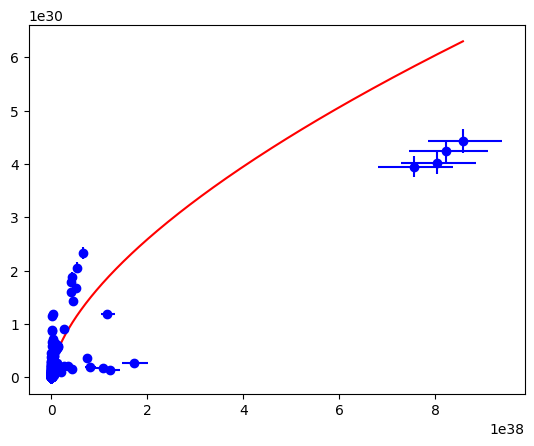

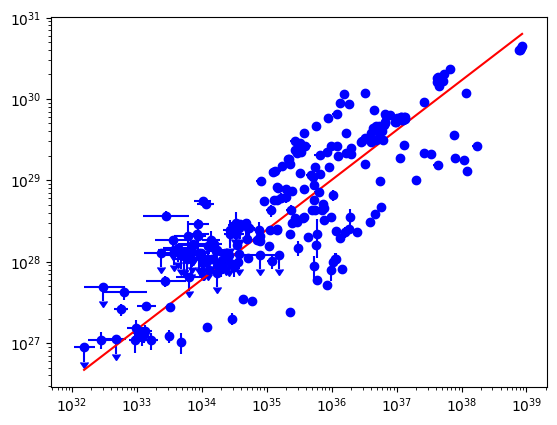

In [ ]:
plt.errorbar( Lx, Lr, yerr=[Lr_unc_l, Lr_unc_u], xerr=[ Lx_unc_l, Lx_unc_u], uplims=Lr_uplims, xuplims=Lx_uplims, fmt='o', color='blue', label='Data Points' )
y = alpha * (x_plot ** beta)
plt.plot( x_plot, y, color='red', label=f'Fit: Lr = {alpha} * Lx^{beta}' )
plt.show()


plt.errorbar( Lx, Lr, yerr=[Lr_unc_l, Lr_unc_u], xerr=[ Lx_unc_l, Lx_unc_u], uplims=Lr_uplims, xuplims=Lx_uplims, fmt='o', color='blue', label='Data Points' )
y = alpha * (x_plot ** beta)
plt.plot( x_plot, y, color='red', label=f'Fit: Lr = {alpha} * Lx^{beta}' )
plt.xscale('log')
plt.yscale('log')
plt.show()

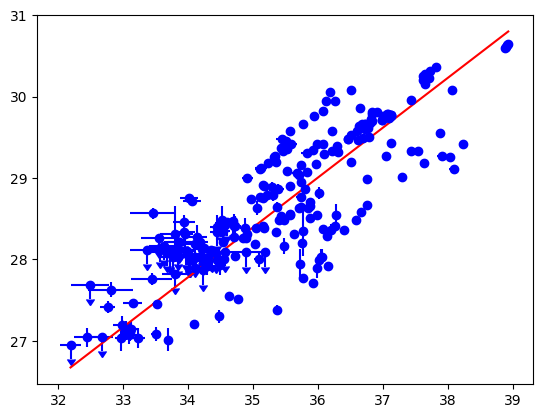

In [17]:
# Converting to log space

x = np.log10(Lx)
y = np.log10(Lr)

# Conservative approach for uncertainties
xerr = np.maximum ( np.log10(Lx + Lx_unc_u) - np.log10(Lx), np.log10(Lx) - np.log10(Lx - Lx_unc_l) )
yerr = np.maximum ( np.log10(Lr + Lr_unc_u) - np.log10(Lr), np.log10(Lr) - np.log10(Lr - Lr_unc_l) )

plt.errorbar( x, y, yerr=yerr, xerr=xerr, uplims=Lr_uplims, xuplims=Lx_uplims, fmt='o', color='blue', label='Data Points' )
y_fit = np.log10(alpha) + beta * x_plot_lin
plt.plot( x_plot_lin, y_fit, color='red', label=f'Fit: log(Lr) = log({alpha}) + {beta} * log(Lx)' )
plt.show()


In [18]:
uplims = Lr_uplims
print("Number of uplims: ", sum(uplims))

Number of uplims:  40


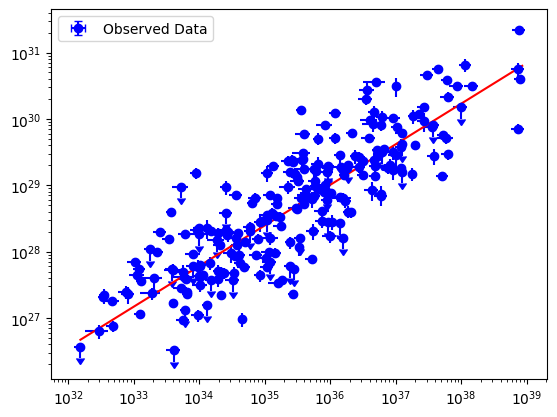

Number of uplims:  39


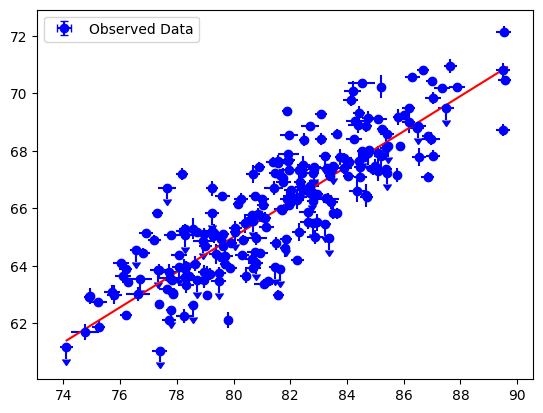

In [27]:
## GENERATE SIMILAR MOCK DATASET


# Linear space
xtrue = Lx
xerr= 0.2*xtrue
#xerr = np.minimum(0.3*xtrue, np.maximum(Lx_unc_l, Lx_unc_u))
xobs = xtrue + np.random.normal(size=len(xtrue)) * xerr

ymean = alpha * (xtrue ** beta) 
eps_log = np.random.normal(size=len(ymean))* sigma_eps_log
ytrue = ymean* 10**eps_log
yerr = np.random.uniform(0.05*ytrue, 0.35*ytrue, size=ytrue.shape)
yobs = ytrue + np.random.normal(size=len(ytrue)) * yerr
    
uplims_obs = (yobs< (3*yerr))
yobs[uplims_obs] = 3*yerr[uplims_obs]


plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, uplims =uplims_obs, fmt='o', label='Observed Data', color='blue')
plt.yscale('log')
plt.xscale('log')
y = alpha * (x_plot ** beta)
plt.plot( x_plot, y, color='red' )
plt.legend()
plt.show()

print("Number of uplims: ", sum(uplims_obs))



# Convert to log space
x = np.log(xobs)
y = np.log(yobs)
xerr = np.maximum ( np.log(xobs + xerr) - np.log(xobs), np.log(xobs) - np.log(xobs - xerr) )
yerr = np.maximum ( np.log(yobs + yerr) - np.log(yobs), np.log(yobs) - np.log(yobs - yerr) )    
plt.errorbar(x, y, xerr=xerr, yerr=yerr, uplims = uplims_obs, fmt='o', label='Observed Data', color='blue')
x_plot_lin = np.log(x_plot)
y_fit = np.log(alpha) + beta * x_plot_lin
plt.plot( x_plot_lin  , y_fit, color='red' )
plt.legend()
plt.show()


Number of uplims:  47


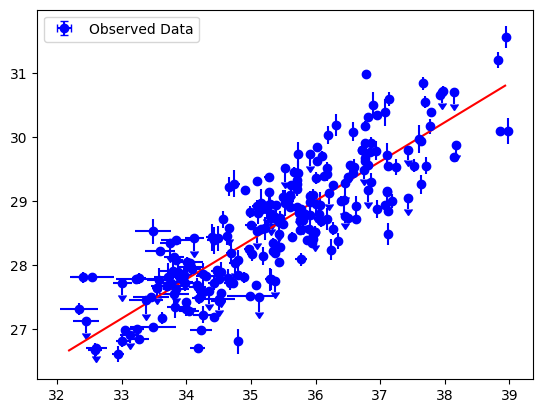

In [22]:
## GENERATE SIMILAR MOCK DATASET IN LOG SPACE DIRECTLY


# Generate sample data in log space directly
xtrue = np.log10(Lx)
xerr = np.maximum ( np.log10(Lx + Lx_unc_u) - np.log10(Lx), np.log10(Lx) - np.log10(Lx - Lx_unc_l) )
xobs = xtrue + np.random.normal(size=len(xtrue)) * xerr

# Log space
ymean = norm_lin + beta * xtrue 
ytrue = ymean + np.random.normal(size=len(ymean))* sigma_eps_log

# Linear space -- just easier in terms of understanding the <3sigma rule
ytrue_lin = 10**ytrue
yerr_lin = np.random.uniform(0.05*ytrue_lin, 0.4*ytrue_lin, size=ytrue_lin.shape) 
yobs_lin = ytrue_lin + np.random.normal(size=len(ytrue_lin)) * yerr_lin
uplims_obs = (yobs_lin< (3*yerr_lin))
yobs_lin[uplims_obs] = 3*yerr_lin[uplims_obs]

# Convert back to log space
yerr = np.maximum ( np.log10(ytrue_lin + yerr_lin) - np.log10(ytrue_lin), np.log10(ytrue_lin) - np.log10(ytrue_lin - yerr_lin) )
yobs = np.log10(yobs_lin)
    

print("Number of uplims: ", sum(uplims_obs))

plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, uplims = uplims_obs, fmt='o', label='Observed Data', color='blue')
x_plot_lin = np.log10(x_plot)
y_fit = np.log10(alpha) + beta * x_plot_lin
plt.plot( x_plot_lin  , y_fit, color='red' )
plt.legend()
plt.show()
